In [14]:
import os
import sys
import pandas as pd
import re

In [15]:
test_df = pd.read_csv('../../data/spanish/test.csv')
train_df = pd.read_csv('../../data/spanish/train.csv')
val_df = pd.read_csv('../../data/spanish/valid.csv')


test_df.head()

,text,label,source
0,"@user jajajaja dale, hacete la boluda vos jaja...",negative,intertass_2017
1,cada vez que cito un tweet se va la ubicación ...,neutral,intertass_2017
2,@user MAAAAE RAJADO! Pero lo bueno es q uno se...,positive,intertass_2017
3,Bueno hoy fui a almorzar a Nanay con otras 3 d...,negative,intertass_2017
4,Necesito seguir a mas cuentas camren shippers ...,neutral,intertass_2017


In [16]:
# from sklearn.model_selection import train_test_split

# train_df, _ = train_test_split(
#     train_df,
#     test_size = 0.6 ,
#     stratify = train_df['label'],
#     random_state = 42
# )

In [17]:
train_df = train_df[train_df["label"] != "neutral"]
test_df  = test_df[test_df["label"]  != "neutral"]
val_df   = val_df[val_df["label"]   != "neutral"]

mapping = {'negative': 0, 'positive': 1}

# Create a new column with mapped values
train_df['sentiment_num'] = train_df['label'].map(mapping)
test_df['sentiment_num'] = test_df['label'].map(mapping)
val_df['sentiment_num'] = val_df['label'].map(mapping)

In [18]:
url_pattern = re.compile(r"http\S+|www\.\S+")
mention_pattern = re.compile(r"@\w+")
hashtag_pattern = re.compile(r"#(\w+)")
rt_pattern = re.compile(r"^RT\s+@\w+:\s*")

def normalize_elongation(word, max_repeat=2):
    return re.sub(r"(.)\1{"+str(max_repeat)+r",}", r"\1"*max_repeat, word)

def clean_tweet(text: str) -> str:
    if not isinstance(text, str):
        return ""
    
    text = rt_pattern.sub("", text)
    text = url_pattern.sub(" URL ", text)
    text = mention_pattern.sub(" @usuario ", text)
    text = hashtag_pattern.sub(r"\1", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()
    tokens = []
    for tok in text.split():
        tokens.append(normalize_elongation(tok))
    text = " ".join(tokens)

    return text



train_df["clean_text"] = train_df["text"].apply(clean_tweet)
test_df["clean_text"] = test_df["text"].apply(clean_tweet)
val_df["clean_text"] = val_df["text"].apply(clean_tweet)

In [19]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW
from datasets import Dataset

model_name = "bert-base-multilingual-uncased"
tok = BertTokenizer.from_pretrained(model_name)
MAX_LEN = 128

def tokenize(batch):
    return tok(
        batch["text"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

train_encodings = tokenize(train_df)
val_encodings = tokenize(val_df)
test_encodings = tokenize(test_df)


/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = SentimentDataset(train_encodings, train_df["sentiment_num"].values)
val_dataset = SentimentDataset(val_encodings, val_df["sentiment_num"].values)
test_dataset = SentimentDataset(test_encodings, test_df["sentiment_num"].values)

In [21]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, shuffle = True)
#change number of labels based on keep/drop neutral class
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir="results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 50%|█████     | 77/154 [01:01<00:56,  1.36it/s]

{'loss': 0.5896, 'grad_norm': 12.777090072631836, 'learning_rate': 1e-05, 'epoch': 1.0}


                                                
 50%|█████     | 77/154 [01:04<00:56,  1.36it/s]

{'eval_loss': 0.48133978247642517, 'eval_runtime': 2.9155, 'eval_samples_per_second': 74.088, 'eval_steps_per_second': 4.802, 'epoch': 1.0}


100%|██████████| 154/154 [02:09<00:00,  1.33it/s]

{'loss': 0.3912, 'grad_norm': 3.4870142936706543, 'learning_rate': 0.0, 'epoch': 2.0}


                                                 
100%|██████████| 154/154 [02:12<00:00,  1.33it/s]

{'eval_loss': 0.4811168313026428, 'eval_runtime': 3.0032, 'eval_samples_per_second': 71.924, 'eval_steps_per_second': 4.662, 'epoch': 2.0}


100%|██████████| 154/154 [02:14<00:00,  1.15it/s]

{'train_runtime': 134.0539, 'train_samples_per_second': 18.291, 'train_steps_per_second': 1.149, 'train_loss': 0.49038963813286324, 'epoch': 2.0}


TrainOutput(global_step=154, training_loss=0.49038963813286324, metrics={'train_runtime': 134.0539, 'train_samples_per_second': 18.291, 'train_steps_per_second': 1.149, 'total_flos': 161287076935680.0, 'train_loss': 0.49038963813286324, 'epoch': 2.0})

In [22]:
metrics = trainer.evaluate()
print(metrics)

100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

{'eval_loss': 0.4811168313026428, 'eval_runtime': 3.0651, 'eval_samples_per_second': 70.472, 'eval_steps_per_second': 4.568, 'epoch': 2.0}


In [23]:
predictions = trainer.predict(val_dataset)

100%|██████████| 14/14 [00:02<00:00,  4.85it/s]


In [24]:
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, classification_report

logits = predictions.predictions      # or predictions[0]
labels = predictions.label_ids        # or predictions[1]

y_pred = np.argmax(logits, axis=-1)

print("Accuracy:", accuracy_score(labels, y_pred))
print("F1 (macro):", f1_score(labels, y_pred, average="macro"))

print(
    classification_report(
        labels,
        y_pred,
        #target_names=["negative", "neutral", "positive"]
        target_names=["negative","positive"]
    )
)

Accuracy: 0.8009259259259259
F1 (macro): 0.8007166305490592
              precision    recall  f1-score   support

    negative       0.82      0.77      0.79       108
    positive       0.78      0.83      0.81       108

    accuracy                           0.80       216
   macro avg       0.80      0.80      0.80       216
weighted avg       0.80      0.80      0.80       216



Test Dataset

In [25]:
pred = trainer.predict(test_dataset)
y_true = test_df["sentiment_num"]
y_pred = np.argmax(pred.predictions, axis=1)


logits = pred.predictions   
labels = pred.label_ids   


print("Accuracy:", accuracy_score(labels, y_pred))
print("F1 (macro):", f1_score(labels, y_pred, average="macro"))

print(
    classification_report(
        labels,
        y_pred,
        #target_names=["negative", "neutral", "positive"]
        target_names=["negative","positive"]
    )
)

100%|██████████| 14/14 [00:02<00:00,  4.78it/s]

Accuracy: 0.7129629629629629
F1 (macro): 0.7125686813186813
              precision    recall  f1-score   support

    negative       0.73      0.68      0.70       108
    positive       0.70      0.75      0.72       108

    accuracy                           0.71       216
   macro avg       0.71      0.71      0.71       216
weighted avg       0.71      0.71      0.71       216



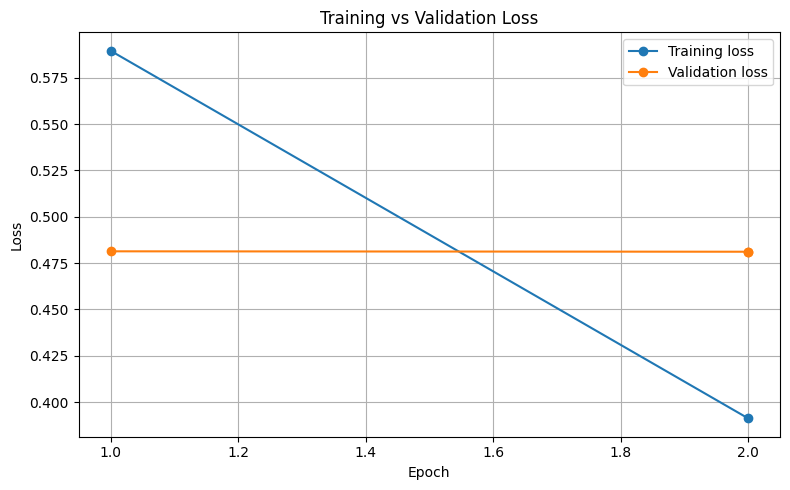

In [26]:
import matplotlib.pyplot as plt

# After training:
# trainer.train()

logs = pd.DataFrame(trainer.state.log_history)

# Separate train and eval logs
train_logs = logs[logs["loss"].notna()][["epoch", "loss"]]
eval_logs  = logs[logs["eval_loss"].notna()][["epoch", "eval_loss"]]

plt.figure(figsize=(8, 5))

plt.plot(train_logs["epoch"], train_logs["loss"], marker="o", label="Training loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], marker="o", label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()